# Лабораторная работа №5. Линейные методы. Задание

In [2]:
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

### 1. Загрузка и преобразование данных
Зарегистрируйтесь на [Kaggle](www.kaggle.com), если вы не сделали этого раньше, зайдите на [страницу](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) соревнования и скачайте данные. Первым делом загрузим обучающую и тестовую выборки и посмотрим на данные.

In [3]:
# загрузим обучающую и тестовую выборки
train_df = pd.read_csv('data/catch/train_sessions.csv',
                       index_col='session_id')
test_df = pd.read_csv('data/catch/test_sessions.csv',
                      index_col='session_id')

# приведем колонки time1, ..., time10 к временному формату
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# отсортируем данные по времени
train_df = train_df.sort_values(by='time1')

# посмотрим на заголовок обучающей выборки
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


В обучающей выборке содержатся следующие признаки:
    - site1 – индекс первого посещенного сайта в сессии
    - time1 – время посещения первого сайта в сессии
    - ...
    - site10 – индекс 10-го посещенного сайта в сессии
    - time10 – время посещения 10-го сайта в сессии
    - target – целевая переменная, 1 для сессий Элис, 0 для сессий других пользователей
    
Сессии пользователей выделены таким образом, что они не могут быть длиннее получаса или 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд либо когда сессия заняла по времени более 30 минут.

В таблице встречаются пропущенные значения, это значит, что сессия состоит менее, чем из 10 сайтов. Заменим пропущенные значения нулями и приведем признаки к целому типу. Также загрузим словарь сайтов и посмотрим, как он выглядит:

In [4]:
# приведем колонки site1, ..., site10 к целочисленному формату и заменим пропуски нулями
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

# загрузим словарик сайтов
with open(r"data/catch/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# датафрейм словарика сайтов
sites_dict_df = pd.DataFrame(list(site_dict.keys()), 
                          index=list(site_dict.values()), 
                          columns=['site'])
print(u'всего сайтов:', sites_dict_df.shape[0])
sites_dict_df.head()

всего сайтов: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


Выделим целевую переменную и объединим выборки, чтобы вместе привести их к разреженному формату.

In [5]:
# наша целевая переменная
y_train = train_df['target']

# объединенная таблица исходных данных
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# индекс, по которому будем отделять обучающую выборку от тестовой
idx_split = train_df.shape[0]

Для самой первой модели будем использовать только посещенные сайты в сессии (но не будем обращать внимание на временные признаки). За таким выбором данных для модели стоит такая идея:  *у Элис есть свои излюбленные сайты, и чем чаще вы видим эти сайты в сессии, тем выше вероятность, что это сессия Элис и наоборот.*

Подготовим данные, из всей таблицы выберем только признаки `site1, site2, ... , site10`. Напомним, что пропущенные значения заменены нулем. Вот как выглядят первые строки таблицы:

In [6]:
# табличка с индексами посещенных сайтов в сессии
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


Сессии представляют собой последовательность индексов сайтов и данные в таком виде неудобны для линейных методов. В соответствии с нашей гипотезой (у Элис есть излюбленные сайты) надо преобразовать эту таблицу таким образом, чтобы каждому возможному сайту соответствовал свой отдельный признак (колонка), а его значение равнялось бы количеству посещений этого сайта в сессии. Это делается в две строчки:

In [7]:
from scipy.sparse import csr_matrix

In [8]:
csr_matrix(full_sites)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 3195430 stored elements and shape (336358, 10)>

In [9]:
# последовательность с индексами
sites_flatten = full_sites.values.flatten()

# искомая матрица
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0] + 10, 10)))[:, 1:]

Еще один плюс использования разреженных матриц в том, что для них имеются специальные реализации как матричных операций, так и алгоритмов машинного обучения, что подчас позволяет ощутимо ускорить операции за счет особенностей структуры данных. Это касается и логистической регрессии. Вот теперь у нас все готово для построения нашей первой модели.

### 2. Построение первой модели

Итак, у нас есть алгоритм и данные для него, построим нашу первую модель, воспользовавшись релизацией [логистической регрессии](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) из пакета `sklearn` с параметрами по умолчанию. Первые 90% данных будем использовать для обучения (обучающая выборка отсортирована по времени), а оставшиеся 10% для проверки качества (validation). 

**Напишите простую функцию, которая будет возвращать качество модели на отложенной выборке, и обучите наш первый классификатор**.

In [10]:
def get_auc_lr_valid(X, y, C=1.0, ratio = 0.9, seed=17):
    '''
    X, y – выборка
    ratio – в каком отношении поделить выборку
    C, seed – коэф-т регуляризации и random_state 
              логистической регрессии
    '''
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio)

    logit = LogisticRegression(C=C, random_state=seed)
    logit.fit(X_train, y_train)

    y_pred = logit.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_pred)
    
    return auc

**Посмотрите, какой получился ROC AUC на отложенной выборке.**

In [11]:
# Ваш код здесь
X_tain = full_sites_sparse[:idx_split, :]
roc_auc = get_auc_lr_valid(X_tain, y_train)
roc_auc

np.float64(0.9206322967532817)

Будем считать эту модель нашей первой отправной точкой (baseline). Для построения модели для прогноза на тестовой выборке **необходимо обучить модель заново уже на всей обучающей выборке** (пока наша модель обучалась лишь на части данных), что повысит ее обобщающую способность:

In [12]:
# функция для записи прогнозов в файл
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

**Обучите модель на всей выборке, сделайте прогноз для тестовой выборки и сделайте посылку в соревновании**.

In [13]:
# Ваш код здесь
logit = LogisticRegression()
logit.fit(X_tain, y_train)

# Делаем прогноз для тестовой выборки
y_pred = logit.predict_proba(full_sites_sparse[idx_split:, :])[:, 1]

# Создаем файл для посылки
write_to_submission_file(y_pred, 'baseline_submission.csv')

Если вы выполните эти действия и загрузите ответ на [странице](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) соревнования, то воспроизведете первый бенчмарк "Logit".

### 3. Улучшение модели, построение новых признаков

Создайте такой признак, который будет представлять собой число вида ГГГГММ от той даты, когда проходила сессия, например 201407 -- 2014 год и 7 месяц. Таким образом, мы будем учитывать помесячный [линейный тренд](http://people.duke.edu/~rnau/411trend.htm) за весь период предоставленных данных.

In [14]:
# Ваш код здесь
# full_df['time1'].dt.year
full_df['start_month'] = full_df['time1'].dt.year * 100 + full_df['time1'].dt.month

Добавьте новый признак, предварительно отмасштабировав его с помощью `StandardScaler`, и снова посчитайте ROC AUC на отложенной выборке.

In [15]:
# Ваш код здесь
scaler = StandardScaler()
full_df['start_month_scaled'] = scaler.fit_transform(full_df['start_month'].values.reshape(-1, 1))

X_train_scaled = full_df['start_month_scaled'][:idx_split].values.reshape(-1, 1)
X_test_scaled = full_df['start_month_scaled'][idx_split:].values.reshape(-1, 1)

roc_auc_with_new_feature = get_auc_lr_valid(hstack([full_sites_sparse[:idx_split, :], X_train_scaled]),
                                           y_train)
roc_auc


np.float64(0.9206322967532817)

**Добавьте два новых признака: start_hour и morning.**

Признак `start_hour` – это час в который началась сессия (от 0 до 23), а бинарный признак `morning` равен 1, если сессия началась утром и 0, если сессия началась позже (будем считать, что утро это если `start_hour равен` 11 или меньше).

**Посчитйте ROC AUC на отложенной выборке для выборки с:**
- сайтами, `start_month` и `start_hour`
- сайтами, `start_month` и `morning`
- сайтами, `start_month`, `start_hour` и `morning`

In [16]:
# Ваш код здесь
full_df['start_hour'] = full_df['time1'].dt.hour
# morning
full_df['morning'] = (full_df['start_hour'] <= 11).astype(int)

# Масштабируем новые признаки
scaler = StandardScaler()
full_df[['start_hour_scaled', 'morning_scaled']] = scaler.fit_transform(full_df[['start_hour', 'morning']])

# Разделяем выборку
def stack(X_tain, keys, isTrain = True):
    res = X_tain
    for key in keys:
        data = full_df[key][:idx_split].values.reshape(-1,1) if isTrain else full_df[key][idx_split:].values.reshape(-1,1)
        res = hstack([
            res,
            data,
        ])
    return res

X_train_hour_scaled = stack(
    full_sites_sparse[:idx_split, :], 
    ["start_month_scaled", "start_hour_scaled"]
)
X_train_morning_scaled = stack(
    full_sites_sparse[:idx_split, :], 
    ["start_month_scaled", "morning_scaled"]
)
X_train_hour_morning_scaled = stack(
    full_sites_sparse[:idx_split, :], 
    ["start_month_scaled", "start_hour_scaled", "morning_scaled"]
)

X_test_hour_scaled = stack(
    full_sites_sparse[idx_split:, :], 
    ["start_month_scaled", "start_hour_scaled"],
    False
)
X_test_morning_scaled = stack(
    full_sites_sparse[idx_split:, :], 
    ["start_month_scaled", "morning_scaled"],
    False
)
X_test_hour_morning_scaled = stack(
    full_sites_sparse[idx_split:, :], 
    ["start_month_scaled", "start_hour_scaled", "morning_scaled"],
    False
)

roc_auc_with_hour = get_auc_lr_valid(X_train_hour_scaled, y_train)
print(f'start_hour: {roc_auc_with_hour}')

roc_auc_with_morning = get_auc_lr_valid(X_train_morning_scaled, y_train)
print(f'morning: {roc_auc_with_morning}')

roc_auc_with_hour_morning = get_auc_lr_valid(X_train_hour_morning_scaled, y_train)
print(f'start_hour & morning: {roc_auc_with_hour_morning}')


start_hour: 0.9380056127825313
morning: 0.945022899311768
start_hour & morning: 0.9503927103198031


### 4. Подбор коэффицициента регуляризации

Итак, мы ввели признаки, которые улучшают качество нашей модели по сравнению с первым бейслайном. Можем ли мы добиться большего значения метрики? После того, как мы сформировали обучающую и тестовую выборки, почти всегда имеет смысл подобрать оптимальные гиперпараметры -- характеристики модели, которые не изменяются во время обучения. Например, на 3 неделе вы проходили решающие деревья, глубина дерева это гиперпараметр, а признак, по которому происходит ветвление и его значение -- нет. В используемой нами логистической регрессии веса каждого признака изменяются и во время обучения находится их оптимальные значения, а коэффициент регуляризации остается постоянным. Это тот гиперпараметр, который мы сейчас будем оптимизировать.

Посчитайте качество на отложенной выборке с коэффициентом регуляризации, который по умолчанию `C=1`:

In [17]:
# Ваш код здесь
roc_auc = get_auc_lr_valid(X_train_hour_morning_scaled, y_train)
roc_auc

np.float64(0.9444661114393919)

Постараемся побить этот результат за счет оптимизации коэффициента регуляризации. Возьмем набор возможных значений C и для каждого из них посчитаем значение метрики на отложенной выборке.

Найдите `C` из `np.logspace(-3, 1, 10)`, при котором ROC AUC на отложенной выборке максимален. 

In [18]:
# Ваш код здесь
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

param_grid = {'logisticregression__C': np.logspace(-3, 1, 10)}

pipeline = make_pipeline(LogisticRegression())

grid_search = GridSearchCV(pipeline, param_grid, scoring='roc_auc')
grid_search.fit(X_train_hour_morning_scaled, y_train)

best_C = grid_search.best_params_['logisticregression__C']
best_score_roc = get_auc_lr_valid(X_train_hour_morning_scaled, y_train, C=best_C)
print(f'Best C: {best_C}')
print(f'Best score: {best_score_roc}')

Best C: 1.2915496650148828
Best score: 0.949168239568084


Наконец, обучите модель с найденным оптимальным значением коэффициента регуляризации и с построенными признаками `start_hour`, `start_month` и `morning`. Если вы все сделали правильно и загрузите это решение, то повторите второй бенчмарк соревнования.

In [19]:
# Ваш код здесь
logit_optimal_C = LogisticRegression(C=best_C)

logit_optimal_C.fit(X_train_hour_morning_scaled, y_train)

test_predict_proba_optimal_C = logit_optimal_C.predict_proba(X_test_hour_morning_scaled)[:, 1]

write_to_submission_file(test_predict_proba_optimal_C, 'submission_optimal_C.csv')

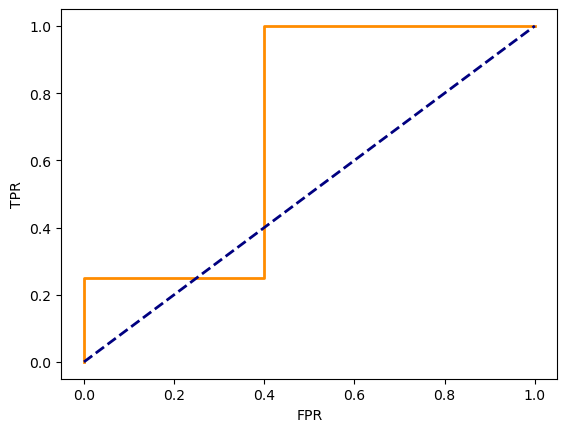

[0.  0.  0.4 0.4 1. ] [0.   0.25 0.25 1.   1.  ] [ inf 0.95 0.8  0.5  0.1 ]


In [25]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_true = [-1, -1, -1, -1, -1, 1, 1, 1, 1]  # Истинные метки
y_pred_proba = [0.1, 0.3, 0.8, 0.9, 0.4, 0.5, 0.7, 0.6, 0.95]  # Вероятности

fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, )
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Случайный классификатор
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
print(fpr, tpr, thresholds)